# Read KNMI observations using hydropandas

This notebook introduces how to use the `hydropandas` package to read, process and visualise KNMI data.

## <a id=top></a>Notebook contents

1. [KnmiObs](#KnmiObs)
2. [Get KNMI data](#reading)
3. [Get ObsCollections](#readingOC)

In [1]:
from hydropandas import ObsCollection
from hydropandas.io import io_knmi
from hydropandas.observation import KnmiObs
from IPython.display import display

import pandas as pd
import numpy as np

## KnmiObs<a id=KNMIObs></a>

The hydropandas package has a function to read all kinds of KNMI observation. These are stored in a `KnmiObs` object. With the code below we get the Evaporation in [m/day] for KNMI station 344 (Rotterdam Airport).

In [2]:
o = KnmiObs.from_knmi(344, 'EV24')
o.head()

,EV24
2019-12-30 01:00:00,0.0002
2019-12-31 01:00:00,0.0005
2020-01-01 01:00:00,0.0004
2020-01-02 01:00:00,0.0001
2020-01-03 01:00:00,0.0001


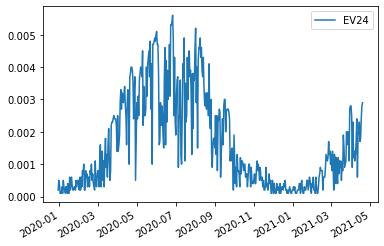

In [3]:
o.plot();

**attributes**

A `KnmiObs` object has the following attributes:

* `name`: station name and variable
* `x`: x-coördinate in m RD
* `y`: y-coördinate in m RD
* `station`: station number
* `meta`: dictionary with other metadata

In [4]:
print(f"name: {o.name}")
print(f"x,y: {(o.x, o.y)}")
print(f"station: {o.station}")
print("metadata:")
for key, item in o.meta.items():
    print(f'    {key}: {item}')

name: EV24 Rotterdam
x,y: (90598.0, 442813.0)
station: 344
metadata:
    EV24: Referentiegewasverdamping (Makkink) (in m) / Potential evapotranspiration (Makkink) (in m)
    x: 90598.0
    y: 442813.0
    station: 344
    name: EV24 Rotterdam


## Get KNMI data<a id=reading></a>

There are 2 main functions to obtain KNMI data:

1. `KnmiObs.from_knmi`
2. `KnmiObs.from_nearest_xy`

Below you can see how they can be called. Notice that they return the same data because station 344 is nearest to the given xy coördinates.

In [5]:
o1 = KnmiObs.from_knmi(344, 'EV24')
o2 = KnmiObs.from_nearest_xy(90600, 442800, 'EV24')
o1.equals(o2)

True

**read options**

The `KnmiObs.from_knmi` method contains the following keyword arguments:

- `stn`: station number.
- `variable`: the type of measurement you want to get. For a list of all variable names check: http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi
- `startdate`: the start date of the time series you want, default is 1st of January 2019.
- `enddate`: the end date of the time series you want, default is today.
- `fill_missing_obs`: option to fill missing values with values from the nearest KNMI station. If measurements are filled an extra column is added to the time series in which the station number is shown that was used to fill a particular missing value.
- `interval`: time interval of the time series, default is 'daily'
- `raise_exception`: option to raise an error when the requested time series is empty.
- `verbose`: option to print additional information to the screen.

***

The 3 examples below give a brief summary of these options

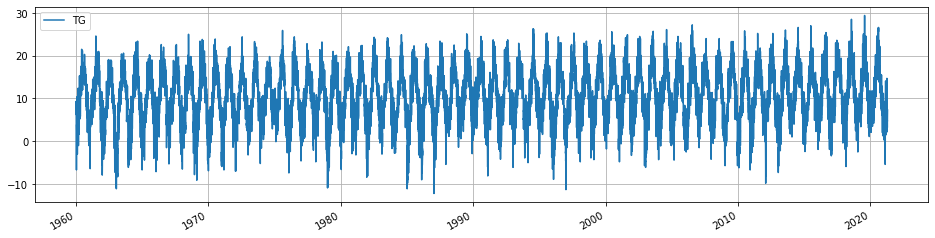

In [6]:
#example 1 get daily average temperature from 1900 till now
o_t = KnmiObs.from_knmi(344, 'TG', startdate='1960')
o_t.plot(figsize=(16,4), grid=True);

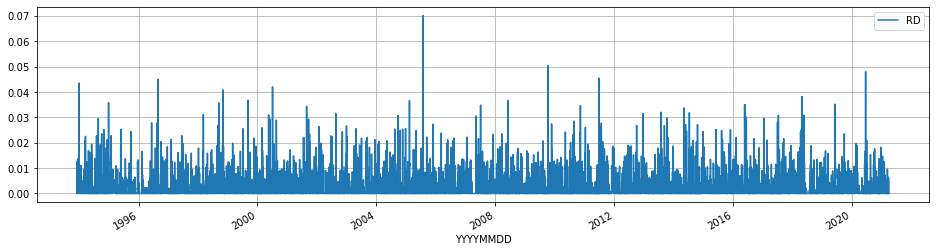

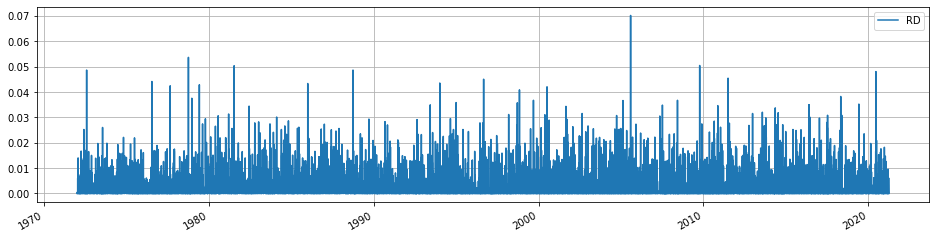

In [7]:
#example 2 get daily average precipitation from 1972 with and without filling missing measurements
o_rd = KnmiObs.from_knmi(892, 'RD', startdate='1972', fill_missing_obs=False)
o_rd.plot(figsize=(16,4), grid=True)

o_rd_filled = KnmiObs.from_knmi(892, 'RD', startdate='1972', fill_missing_obs=True)
o_rd_filled.plot(figsize=(16,4), grid=True);

In [8]:
#see the station_opvulwaarde
display(o_rd.head())
display(o_rd_filled.head())

,RD
YYYYMMDD,
1993-12-07 09:00:00,0.0000
1993-12-08 09:00:00,0.0126
1993-12-09 09:00:00,0.0117
1993-12-10 09:00:00,0.0000
1993-12-11 09:00:00,0.0023


,RD,station_opvulwaarde
1971-12-31 09:00:00,0.0,910
1972-01-01 09:00:00,0.0,910
1972-01-02 09:00:00,0.0,910
1972-01-03 09:00:00,0.0,910
1972-01-04 09:00:00,0.0,910


In [9]:
# example 3 get evaporation and print additional information during download using verbose=True
o_ev = KnmiObs.from_knmi(344, 'EV24', startdate='1972', fill_missing_obs=True, verbose=True)
o_ev

transform EV24, Referentiegewasverdamping (Makkink) (in 0.1 mm) / Potential evapotranspiration (Makkink) (in 0.1 mm) from 0.1 to 1
transform EV24, Referentiegewasverdamping (Makkink) (in mm) / Potential evapotranspiration (Makkink) (in mm) from mm to m
Download EV24 from 344 Rotterdam
station 344 has no measurements before 1987-09-12 01:00:00
station 344 has 5810 missing measurements
trying to fill 5810 measurements with station [210]
transform EV24, Referentiegewasverdamping (Makkink) (in 0.1 mm) / Potential evapotranspiration (Makkink) (in 0.1 mm) from 0.1 to 1
transform EV24, Referentiegewasverdamping (Makkink) (in mm) / Potential evapotranspiration (Makkink) (in mm) from mm to m
trying to fill 5564 measurements with station [330]
transform EV24, Referentiegewasverdamping (Makkink) (in 0.1 mm) / Potential evapotranspiration (Makkink) (in 0.1 mm) from 0.1 to 1
transform EV24, Referentiegewasverdamping (Makkink) (in mm) / Potential evapotranspiration (Makkink) (in mm) from mm to m
try

,EV24,station_opvulwaarde
1971-12-31 01:00:00,0.0001,260
1972-01-01 01:00:00,0.0002,260
1972-01-02 01:00:00,0.0002,260
1972-01-03 01:00:00,0.0002,260
1972-01-04 01:00:00,0.0000,260
...,...,...
2021-04-15 01:00:00,0.0017,NaN
2021-04-16 01:00:00,0.0018,NaN
2021-04-17 01:00:00,0.0024,NaN
2021-04-18 01:00:00,0.0028,NaN


## Get ObsCollections<a id=readingOC></a>

It is also possible to read multiple `KnmiObs` objects at once and store them in an `ObsCollection` object. For this we use the `ObsCollection.from_knmi()` method. Below an example to obtain precipitation (RH) and evaporation (EV24) from the KNMI station of Rotterdam and De Bilt. 

In [10]:
oc = ObsCollection.from_knmi(stns=[344, 260], meteo_vars=['RH', 'EV24'])
oc

,x,y,filename,station,obs
name,,,,,
RH Rotterdam,90598.000000,442813.000000,,344,RH 2019-12-29 0.0000 2019-12-...
RH De Bilt,141002.996557,456772.017696,,260,RH 2019-12-29 0.0000 2019-12-...
EV24 Rotterdam,90598.000000,442813.000000,,344,EV24 2019-12-29 0.0003 2019-12-...
EV24 De Bilt,141002.996557,456772.017696,,260,EV24 2019-12-29 0.0003 2019-12-...


Besides giving a list of stations it is also possible to:
- specify `locations` as a dataframe with x, y coördinates, the function will find the nearest KNMI station for every location.
- specify `xmid` and `ymid` which are 2 arrays corresponding to a structured grid to obtain the nearest KNMI station for every cell in the grid.

In [11]:
ObsCollection.from_knmi(locations=pd.DataFrame(index=['Rotterdam'], data ={'x':77500, 'y':399500}), 
                        meteo_vars=['RH'])

,x,y,filename,station,obs
name,,,,,
RH Woensdrecht,82881.403813,384958.510811,,340,RH 2019-12-28 0.0048 2019-12-...


In [12]:
ObsCollection.from_knmi(xmid=np.array([77500]), ymid=np.array([399500]), 
                        meteo_vars=['RH'])

,x,y,filename,station,obs
name,,,,,
RH Woensdrecht,82881.403813,384958.510811,,340,RH 2019-12-27 0.0105 2019-12-...
